## Generating Diverse and Realistic Datasets for Computer Vision Training

By [Me](https://www.linkedin.com/in/fareed-khan-dev/)

## Introduction

When real-world data is limited or expensive to collect, training custom object detection models has always been a headache - you either need to spend countless hours manually labeling data or deal with the hassle of licensing existing datasets. Even when you find usable data, it often doesn't quite match what you need for your specific research or business case. But here's where things get interesting: the recent boom in AI vision models and image generators has opened up a whole new way to tackle this problem. Instead of the traditional manual grind, we can now use Large Language Models (LLMs) and vision models to create synthetic training data based on our needs. Since there are so many LLMs and image generation models out there now, both open-source and commercial, developers have incredible flexibility in choosing what works best for their specific use case.

This project shows how we can generate custom synthetic datasets for training object detection models, helping developers spend less time on the tedious parts of data preparation and more time on actually solving problems. It's about making the whole process more efficient and accessible.

## Project Architecture

Our system works like a pipeline, with each step building on the previous one to create a complete training dataset. Here's a high-level overview of how it works:

![architecture.png](images/architecture.png)


* First up is our Base Prompt Template - this is where you describe your object and where you might find it. Think of it like giving basic instructions about what you want to detect.

* Next, these instructions get handed off to Text Generation LLMs (like OpenAI, Gemini, or Hugging Face models). These AI models take your basic template and get creative with it, generating lots of different scenarios for your object.

* To make sure we have enough training data, we multiply these prompts (labeled x1, x2, x3... xn) by N. This gives us a huge variety of different scenarios to work with.

* These detailed descriptions then go to Image Generation Models like Stability.ai and DALL-E. These models turn all those text descriptions into actual images we can use for training.

* We can validate the quality of these synthetic images using a pre-trained vision model from hugging face or any other source.

* Once we have our synthetic images, tools like Grounded-SAM automatically label them, adding bounding boxes around the objects we want to detect.

* Then we validate the quality of these annotations using a pre-trained vision models which checks if the bounding boxes are correctly placed. 

* The end result? A complete training dataset where each image comes with its matching bounding box annotations, ready to train an object detection model.

* The best part is how flexible this setup is - you can mix and match different LLMs and image generators based on what works best for your specific needs, whether that's budget, speed, or quality.

## Setup

Make sure Python is installed on your system. You can download it from [here](https://www.python.org/downloads/). Once you have Python installed, you can install the required packages using the following command:

```bash
pip install numpy pandas matplotlib opencv-python Pillow torch diffusers autodistill autodistill-grounding-dino openai autodistill-yolov8 roboflow
```

You can also install the required packages using the `requirements.txt` file:

```bash
pip install -r requirements.txt
```

## Importing Libraries

Next, we import the required libraries:

In [1]:
import os  # For interacting with the operating system
import math  # For mathematical operations
import io  # For file input and output operations
import ast  # For parsing and evaluating Python expressions
import base64  # For base64 encoding and decoding
from io import BytesIO  # For reading and writing files in memory

import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting and visualizations

import cv2  # OpenCV library for computer vision tasks
from PIL import ImageDraw  # For image processing and drawing graphics

import torch  # PyTorch for deep learning
from diffusers import StableDiffusionPipeline  # For text-to-image generation with Stable Diffusion
from autodistill.detection import CaptionOntology  # For labeling/annotation tasks in object detection
from autodistill_grounding_dino import GroundingDINO  # For grounding and detection tasks
from openai import OpenAI  # OpenAI API for AI Chat

## Base Prompt Template

The first step in our pipeline is to create a base prompt template. This is where you describe the object you want to detect and where you might find it. Here's an example of a base prompt template for detecting bears in different environments:

In [2]:
# Define the important objects that must be present in each generated prompt.
important_objects = "brown bear"  # For multiple objects, separate them with commas, e.g., "different kinds of bear, bottles, ... etc."

# Specify the number of prompts to generate.
number_of_prompts = 50  # Define the number of prompts to generate for the image generation task.

# Provide a brief description of the kind of images you want the prompts to depict.
description_of_prompt = "brown bear in different environments"  # Describe the scenario or context for the image generation.

# Generate a formatted instruction set to produce image generation prompts.
# This formatted string will help in creating detailed and diverse prompts for the computer vision model.

base_prompt = f'''
# List of Important Objects:
# The objects listed here must be included in every generated prompt.
Important Objects that must be present in each prompt:
{important_objects}

# Input Details:
# The task is to generate a specific number of prompts related to the description provided.
Input:
Generate {number_of_prompts} realistic prompts related to {description_of_prompt} for image generation.

# Instructions for Prompt Generation:
# - Each prompt should depict real-life behaviors and scenarios involving the objects.
# - All important objects should be included in every prompt.
# - Ensure that the objects are captured at varying distances from the camera:
#   - From very close-up shots to objects in the far background.
# - The prompts should be diverse and detailed to cover a wide range of use cases.

# Output Format:
# - The output should be a Python list containing all the generated prompts as strings.
# - Each prompt should be enclosed in quotation marks and separated by commas within the list.
Output:
Return a Python list containing these prompts as strings for later use in training a computer vision model.
[prompt1, prompt2, ...]
'''

# Print the formatted instruction set for generating prompts.
print(base_prompt)


# List of Important Objects:
# The objects listed here must be included in every generated prompt.
Important Objects that must be present in each prompt:
brown bear

# Input Details:
# The task is to generate a specific number of prompts related to the description provided.
Input:
Generate 50 realistic prompts related to brown bear in different environments for image generation.

# Instructions for Prompt Generation:
# - Each prompt should depict real-life behaviors and scenarios involving the objects.
# - All important objects should be included in every prompt.
# - Ensure that the objects are captured at varying distances from the camera:
#   - From very close-up shots to objects in the far background.
# - The prompts should be diverse and detailed to cover a wide range of use cases.

# Output Format:
# - The output should be a Python list containing all the generated prompts as strings.
# - Each prompt should be enclosed in quotation marks and separated by commas within the list.
O

## Prompt Expansion

Next, we expand our base prompt template using a text generation model. This gives us a wide variety of different scenarios for our object detection model. There are two main ways to do this:
1. Using a pre-trained text generation model API/Locally such as OpenAI's GPT-3, Falcon, or others.
2. Using web interfaces of text generation models like ChatGPT, Gemini, Claude, or others.

### 1. Using LLMs API (eg. OpenAI's GPT)

To use OpenAI's API, you need to sign up for an API key. You can find more information on how to do this [here](https://beta.openai.com/signup/). Once you have your API key, you can use the following code to expand your prompt:

In [3]:
# Initialize the OpenAI API client with your API key.
openai_chat = OpenAI(
    api_key="YOUR_OPENAI_API_KEY"
)

# Generate prompts for image generation using the OpenAI API.
completion = openai_chat.chat.completions.create(
    model="gpt-4o-mini",
    messages=[{"role": "system", "content": base_prompt+ "\n\n your response: [prompt1, prompt2, ...] and do not say anything else and i will be be using ast.literal_eval to convert the string to a list"}]
)

# Extract the generated prompts from the API response.
response = completion.choices[0].message.content

Since the output of the API is a string, we need to convert it into a list of strings.

In [29]:
# Extract the part of the string that contains the variable definition
variable_definition = response.strip()

# Fix the formatting issue by ensuring the string is a valid Python list
if variable_definition.endswith(","):
	variable_definition = variable_definition[:-1] + "]"

# Use ast.literal_eval to safely evaluate the variable definition
prompts = ast.literal_eval(variable_definition)

# Print the first few prompts to verify the output
print(prompts[0:5])

['A brown bear in a dense forest, standing behind a thick tree trunk with leaves and branches covering it from head to paw, looking directly at the camera.', 'A brown bear walking alone in a vast, open tundra, with mountains visible in the far background, and a few birds flying overhead.', "A close-up shot of a brown bear's face, focusing on its eyes and nostrils as it smells the air, with the background blurred.", 'A brown bear standing at the edge of a serene lake, reflecting the beauty of the surrounding landscape in the calm water.', 'A brown bear roaming freely in a meadow filled with wildflowers of various colors, under a clear blue sky with a few white clouds.']


### 2. Using Web Interfaces (eg. ChatGPT)

If you prefer using web interfaces, you can use tools like ChatGPT, Gemini, Claude, or others. These tools provide a user-friendly interface where you can input your prompt and get the expanded output. Here's an example of how you can use ChatGPT to expand your prompt by providing the base prompt template:

![chatgpt_interface.png](images/chatgpt_interface.png)

Once you have your expanded prompts, we can further multiply them to get a larger dataset. This is done by simply repeating the prompts multiple times. Here's an example of how you can multiply your prompts:

In [4]:
# Increase the number of prompts by doubling the existing prompts
prompts = prompts * 2

# Shuffle the prompts to ensure randomness
import random
random.shuffle(prompts)

# Print the total number of prompts after doubling and shuffling
len(prompts)

100


## Image Generation

Now that we have our expanded prompts, we can use image generation models to turn these text descriptions into actual images. There are several image generation models available, such as DALL-E, Stability.ai, and others. Here's an example of how you can use stable diffusion models to generate images based on your prompts:

In [ ]:
# Defining the model name and device to use for the Stable Diffusion pipeline.
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

# Load the Stable Diffusion pipeline with the specified model and device.
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(device)

Now that we have loaded the image generation model, we can use it to generate images based on our prompts. Here's how of how you can generate images based on your prompts:

In [ ]:
# Extract the first 5 prompts for generating images. (sample data)
sample_prompts = prompts[:10]

# Generate images based on the sample prompts using the Stable Diffusion pipeline.
images = pipe(sample_prompts).images

In the above code, we sampled 5 prompts from our expanded prompts and generated images based on those prompts to quickly visualize the results.

Let's create a dataframe to store the generated images and their corresponding prompts for easy visualization and reference.

In [68]:
# Convert the generated images to a format that can be displayed in a DataFrame.
synthetic_data = pd.DataFrame({'Prompt': sample_prompts, 'Image': images})

# Display the synthetic data containing prompts and the corresponding generated images.
synthetic_data

Prompt  \
0  A brown bear in a dense forest, standing behin...   
1  A brown bear walking alone in a vast, open tun...   
2  A close-up shot of a brown bear's face, focusi...   
3  A brown bear standing at the edge of a serene ...   
4  A brown bear roaming freely in a meadow filled...   
5  A brown bear crossing a shallow stream, steppi...   
6  A brown bear in a forest, climbing a tree, wit...   
7  A brown bear on top of a hill, looking out ove...   
8  A brown bear in a snowy landscape, trudging th...   
9  A brown bear at a beach, walking along the sho...   

                                               Image  
0  <PIL.Image.Image image mode=RGB size=512x512 a...  
1  <PIL.Image.Image image mode=RGB size=512x512 a...  
2  <PIL.Image.Image image mode=RGB size=512x512 a...  
3  <PIL.Image.Image image mode=RGB size=512x512 a...  
4  <PIL.Image.Image image mode=RGB size=512x512 a...  
5  <PIL.Image.Image image mode=RGB size=512x512 a...  
6  <PIL.Image.Image image mode=RGB size=512x512 a...  
7  <PIL.Image.Image image mode=RGB size=512x512 a...  
8  <PIL.Image.Image image mode=RGB size=512x512 a...  
9  <PIL.Image.Image image mode=RGB size=512x512 a...

Let's visualize the generated images and see how they look:

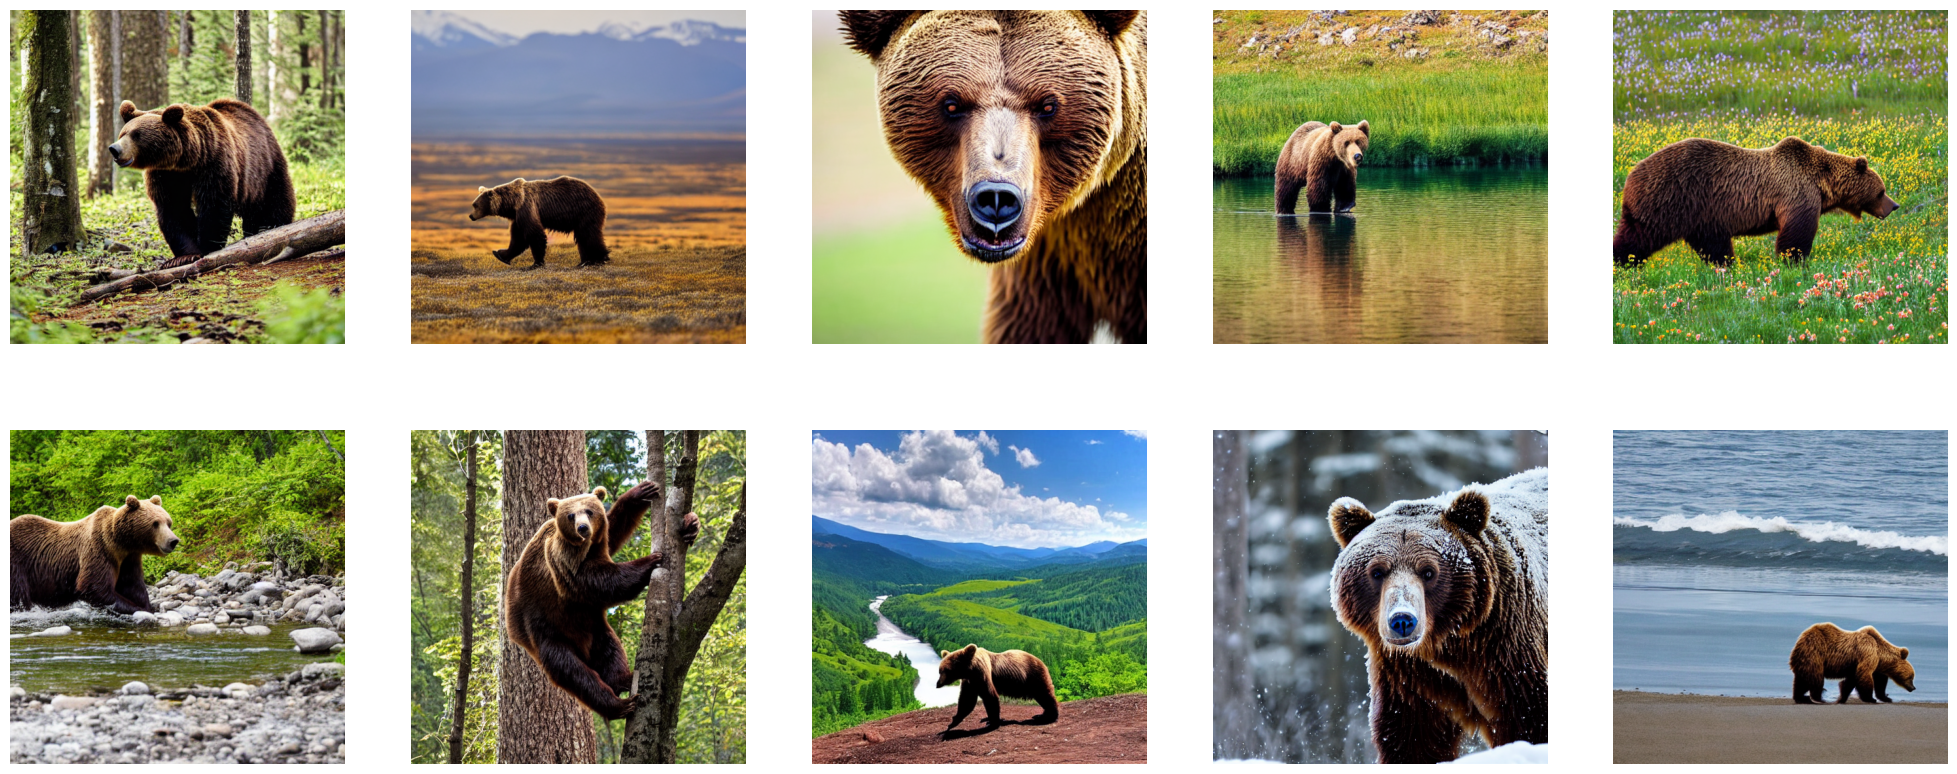

In [69]:
# Define a function to display the images generated from the prompts.
def display_images(dataframe):
    
    # Extract the images from the DataFrame
    images = dataframe['Image']

    # Set up the grid
    max_images_per_row = 5
    rows = (len(images) + max_images_per_row - 1) // max_images_per_row
    columns = min(len(images), max_images_per_row)

    # Create a figure and axis
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))

    # Flatten axes if there's only one row
    if rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Display each image
    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Show the grid of images
    plt.show()

# Display the synthetic images generated from the prompts.
display_images(synthetic_data)

## Validaing the Generated Images

We can improve our `base_prompt` to avoid such such images which are not related to our targeted object but If we are generating tons of images we cannot check if our images are correctly containing that object for example in our case it can easily generate a noisy image of bear for that we can manually check such noisy images because we are working with a sample data but we can also use a pre-trained vision models to perform the validation and recreate those images which contains such errors.

We can use vision models provided by Hugging Face, OpenAI, or any other pre-trained vision model providers. We will use `Qwen/Qwen2-VL-7B-Instruct` an open-source vision model through an API from [Nebius.ai](https://nebius.com/) to validate the quality of the generated images.

The very first step is to create validation prompt which checks if the generated image contains the object we are looking for.

In [9]:
# Define the prompt for the object detection task.
validation_prompt = "Analyze the provided image and determine if it depicts a real bear, which is an animal, excluding any other types of objects or representations. Respond strictly with 'True' for yes or 'False' for no."

Then we can encode the images and pass them to the vision model along with the validation prompt to check if the generated images contain the object we are looking for.

In [10]:
# Initialize the OpenAI API client with your Nebius API key.
openai_chat = OpenAI(
    base_url="https://api.studio.nebius.ai/v1/",
    api_key="YOUR_NEBIUS_API_KEY"
)

# Define a function to validate images using the OpenAI API.
def validate_images(validation_prompt, images):

    # Initialize an empty list to store the validation results
    bools = []

    # Function to encode a PIL image to base64
    def encode_image_pil(image):
        buffer = BytesIO()
        image.save(buffer, format="JPEG")  # Save the image to the buffer in JPEG format
        buffer.seek(0)  # Rewind the buffer to the beginning
        return base64.b64encode(buffer.read()).decode("utf-8")  # Convert to base64

    # Iterate through your images
    for image in images:
        # Convert the PIL image to base64
        base64_image = encode_image_pil(image)

        # Prepare the API payload
        response = openai_chat.chat.completions.create(
            model="Qwen/Qwen2-VL-72B-Instruct",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": validation_prompt},
                        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
                    ],
                }
            ],
        )

        # Append the response to the list
        bools.append(response.choices[0].message.content.replace('.', '').replace('\n', ''))

    # Convert the list of strings to a list of booleans
    bools = [ast.literal_eval(item) for item in bools]
    return bools

# Validate images and add the results as a new column in the dataframe
synthetic_data['bear_class'] = validate_images(validation_prompt, synthetic_data['Image'])

Let's see how our updated dataframe looks like after validation:

In [11]:
synthetic_data

Prompt  \
0  A brown bear in a dense forest, standing behin...   
1  A brown bear walking alone in a vast, open tun...   
2  A close-up shot of a brown bear's face, focusi...   
3  A brown bear standing at the edge of a serene ...   
4  A brown bear roaming freely in a meadow filled...   
5  A brown bear crossing a shallow stream, steppi...   
6  A brown bear in a forest, climbing a tree, wit...   
7  A brown bear on top of a hill, looking out ove...   
8  A brown bear in a snowy landscape, trudging th...   
9  A brown bear at a beach, walking along the sho...   

                                               Image  bear_class  
0  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
1  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
2  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
3  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
4  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
5  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
6  <PIL.Image.Image image mode=RGB size=512x512 a...       False  
7  <PIL.Image.Image image mode=RGB size=512x512 a...       False  
8  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
9  <PIL.Image.Image image mode=RGB size=512x512 a...        True

Two images were found to be noisy so we can recreate them and validate them again to make sure they contain the object we are looking for.

In [12]:
# Define a function to regenerate and validate images based on the validation results.
def regenerate_and_validate_images(dataframe, validation_prompt, pipe):

    # Get rows where bear_class is False (i.e., the image does not depict a bear) and runs the image generation process again for those rows
    rows_to_regenerate = dataframe[dataframe['bear_class'] == False]

    # Extract indices and prompts separately
    indices_to_regenerate = rows_to_regenerate.index
    prompts_to_regenerate = rows_to_regenerate['Prompt'].tolist()

    # Generate images based on the prompts that need to be regenerated.
    images_to_regenerate = pipe(prompts_to_regenerate).images

    # Iterate over the indices and the newly generated images
    for idx, img in zip(indices_to_regenerate, images_to_regenerate):
        dataframe.at[idx, 'Image'] = img

    # Validate only the rows that were regenerated
    dataframe.loc[indices_to_regenerate, 'bear_class'] = validate_images(validation_prompt, dataframe.loc[indices_to_regenerate, 'Image'])

    return dataframe

# Call the function to regenerate and validate images
synthetic_data = regenerate_and_validate_images(synthetic_data, validation_prompt, pipe)

Let's print the dataframe to see if the images were recreated and validated correctly this time:

In [12]:
synthetic_data

Prompt  \
0  A brown bear in a dense forest, standing behin...   
1  A brown bear walking alone in a vast, open tun...   
2  A close-up shot of a brown bear's face, focusi...   
3  A brown bear standing at the edge of a serene ...   
4  A brown bear roaming freely in a meadow filled...   
5  A brown bear crossing a shallow stream, steppi...   
6  A brown bear in a forest, climbing a tree, wit...   
7  A brown bear on top of a hill, looking out ove...   
8  A brown bear in a snowy landscape, trudging th...   
9  A brown bear at a beach, walking along the sho...   

                                               Image  bear_class  
0  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
1  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
2  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
3  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
4  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
5  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
6  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
7  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
8  <PIL.Image.Image image mode=RGB size=512x512 a...        True  
9  <PIL.Image.Image image mode=RGB size=512x512 a...        True

Our dataframe does not contain any noisy images now. Let's visualize the generated images to make sure this time they contain the object we are looking for:

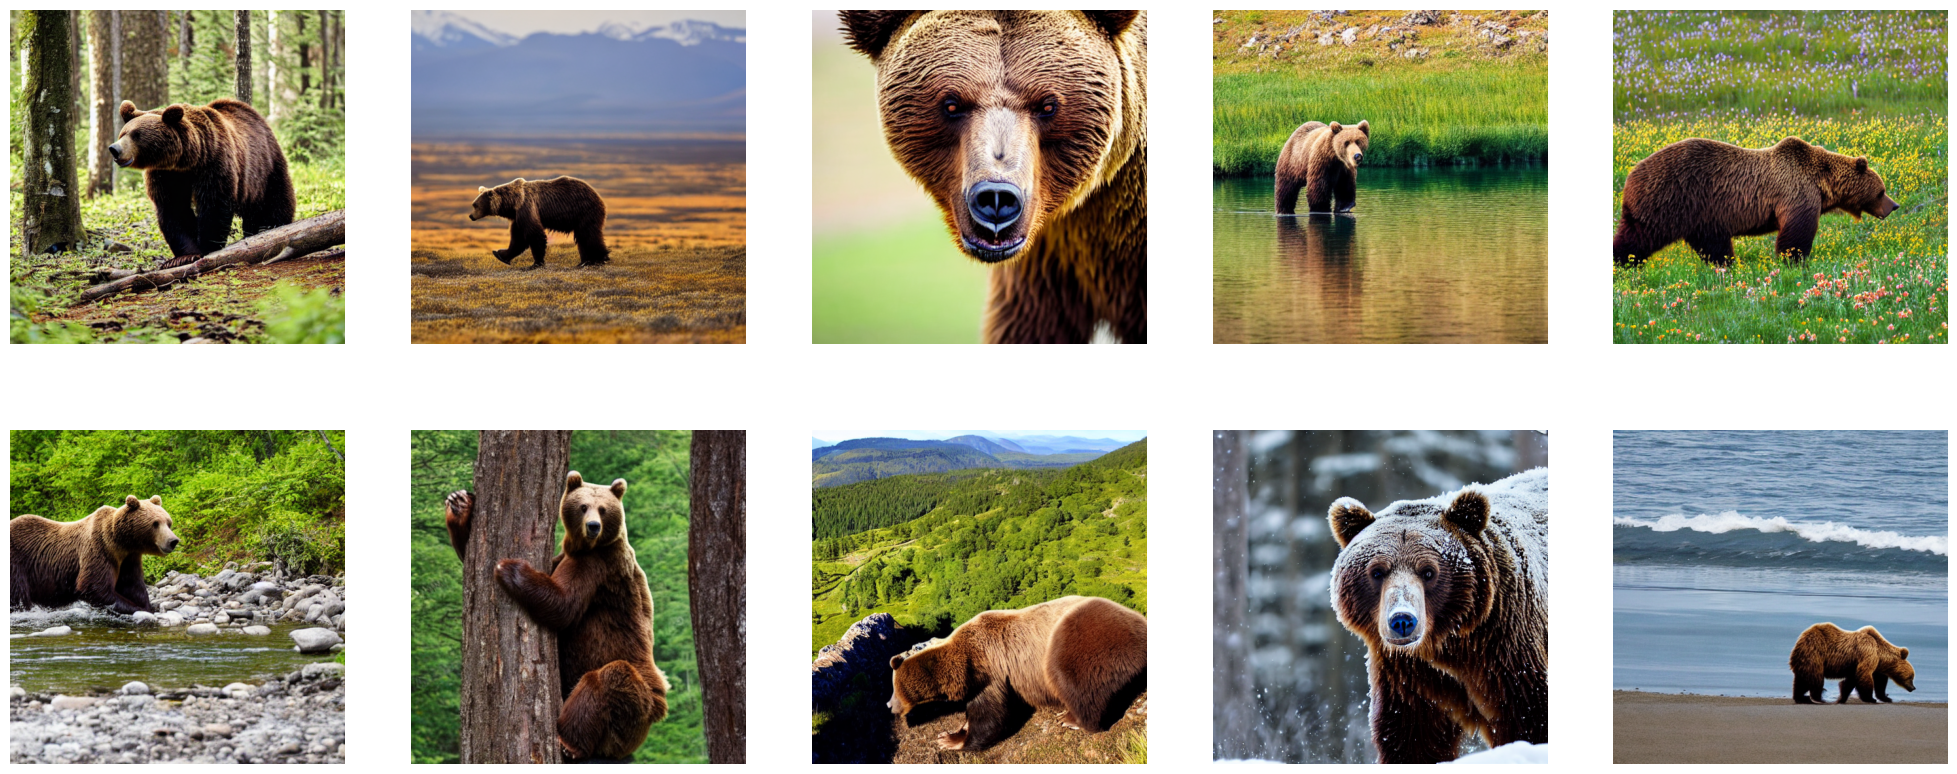

In [81]:
# Display the synthetic images after regenerating and validating the images.
display_images(synthetic_data)

Now that we have successfully validated our generated images, we can move on to the next step in our pipeline - labeling the images with bounding boxes.

## Labeling Images

Once we have our synthetic images, we need to label them with bounding boxes around the objects we want to detect. There are several tools available that can help automate this process, such as Grounded-SAM, Grounded-DINO, and others. We will use Grounded-DINO to label our images with bounding boxes, you can choose any other tool as per your requirements.

The very first is to first define the ontology of the captions that we want to detect. For example in our case, we want to detect bears, so we define the ontology as follows:

In [15]:
# Defining the CaptionOntology for the object "bear" in the generated images.
ontology=CaptionOntology(
    {
        "bear": "bear" # Define the ontology for the object "bear"
    }
)

After that we initialize the Grounded-DINO model with the above ontology:

In [ ]:
# Initialize the GroundingDINO model with the defined ontology.
base_model = GroundingDINO(ontology=ontology)

Grounding-DINO requires the input to be a directory containing images. So we will save the images temporarily to a directory and then pass that directory to the model for grounding.

In [17]:
# Create a temporary directory for saving images
temp_dir = "temp_images"
os.makedirs(temp_dir, exist_ok=True)

# Save the images to the temporary directory
for idx, img in enumerate(synthetic_data['Image']):
    file_path = os.path.join(temp_dir, f"image_{idx}.jpg")
    img.save(file_path)  # Save the PIL image

Now we can label the images in the specified directory using the GroundingDINO model:

In [ ]:
# Label the images using the GroundingDINO model
base_model.label(temp_dir,  # Pass the list of image file paths
                 extension=".jpg",
                 output_folder="labeled_images")

# Optional: Clean up the temporary directory after labeling (if desired)
import shutil
shutil.rmtree(temp_dir)

Once we run the above code, the images will be labeled with bounding boxes around the objects we want to detect. A new folder will be created based on the parameter `output_dir` where the labeled images will be saved.

our `labeled_images` folder will contain two subfolders, `train`, `valid` and one file `data.yaml`. The `train` folder contains the training images with bounding boxes, the `valid` folder contains the validation images with bounding boxes, and the `data.yaml` file contains the metadata about the labeled images.

It will be much better to include labels in the dataframe for easy reference. So let's update the dataframe with the labels.

In [19]:
# Paths to the train and valid directories
train_labels_dir = "labeled_images/train/labels"
valid_labels_dir = "labeled_images/valid/labels"

# Function to map labels to dataframe
def map_labels_to_dataframe(df, train_labels_dir, valid_labels_dir):
    # Combine all label paths
    label_paths = {}
    for label_dir in [train_labels_dir, valid_labels_dir]:
        if os.path.exists(label_dir):
            label_files = sorted(os.listdir(label_dir))  # Ensure order matches `image_{index}`
            for label_file in label_files:
                if label_file.endswith(".txt"):
                    label_index = int(label_file.split('_')[1].split('.')[0])  # Extract index from filename
                    label_paths[label_index] = os.path.join(label_dir, label_file)

    # Read labels and map to dataframe
    labels = []
    for idx in range(len(df)):
        label_path = label_paths.get(idx, None)
        if label_path and os.path.exists(label_path):
            with open(label_path, "r") as f:
                label_content = f.read().strip()  # Read the bounding box info
                labels.append(label_content)
        else:
            labels.append("")  # No label found for this index

    # Assign labels to dataframe
    df['Labels'] = labels
    return df

# Map labels to the dataframe
synthetic_data = map_labels_to_dataframe(synthetic_data, train_labels_dir, valid_labels_dir)

# Optional: Clean up the temporary directory after labeling (if desired)
import shutil
shutil.rmtree("labeled_images")

## Visualizing Labeled Images

Let's visualize the `train` labeled images to see how they look:

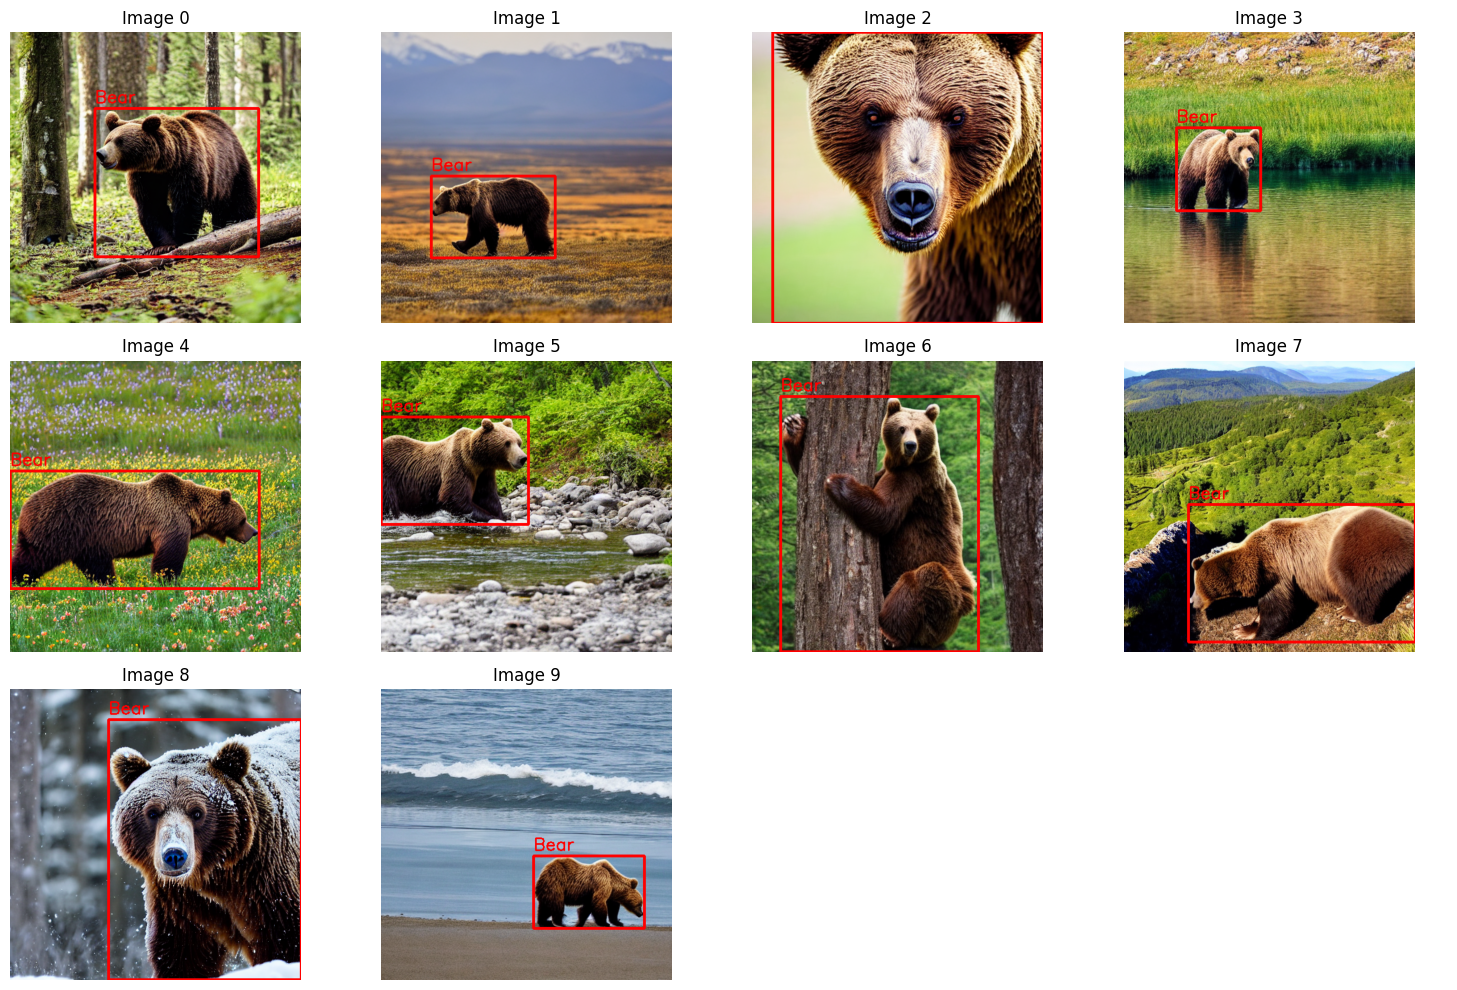

In [88]:
# Helper function to draw bounding boxes on an image
def draw_bboxes(image, bboxes):
    # Convert PIL Image to NumPy array (if needed)
    if isinstance(image, np.ndarray) is False:
        image = np.array(image)
    h, w = image.shape[:2]

    # Draw each bounding box
    for _, xc, yc, ww, hh in bboxes:
        x1, y1, x2, y2 = [int(v) for v in [(xc-ww/2)*w, (yc-hh/2)*h, (xc+ww/2)*w, (yc+hh/2)*h]]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 3)  # Blue bounding box
        cv2.putText(image, 'Bear', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    return image

# Helper function to parse labels from a string
def parse_labels(label_str):
    if not label_str:
        return []
    return [tuple(map(float, line.split())) for line in label_str.split('\n')]

# Grid layout for displaying images
grid_cols = math.ceil(math.sqrt(len(synthetic_data)))
grid_rows = math.ceil(len(synthetic_data) / grid_cols)
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(15, 10))
axes = axes.flatten() if grid_rows * grid_cols > 1 else [axes]

# Plot each image with its bounding boxes
for i, (image, label_str) in enumerate(zip(synthetic_data['Image'], synthetic_data['Labels'])):
    # Parse labels and draw bounding boxes
    bboxes = parse_labels(label_str)
    image_with_boxes = draw_bboxes(image.copy(), bboxes)

    # Display the image
    axes[i].imshow(image_with_boxes)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i}")

# Hide unused axes
for ax in axes[len(synthetic_data):]: ax.axis('off')
plt.tight_layout()
plt.show()

## Validating the Labeled Images

Similar to validating the generated images, we can validate the labeled images using a pre-trained vision model. We will use the same vision model `Qwen/Qwen2-VL-7B-Instruct` to validate the labeled images. We will be checking if the bounding boxes are correctly placed around the objects we want to detect.

The very first step is to create validation prompt to check if the generated image contains the object we are looking for.

In [21]:
# Define the validation prompt for the labeled images.
validation_labeled_prompt = "Evaluate the provided image and its associated bounding box. Determine if the bounding box correctly and fully encloses the entire bear of interest without cutting off any part of it, leaving excessive empty space, or including irrelevant areas. Respond strictly with 'True' if the bounding box is correct or 'False' if it is not."

Next we can draw bounding boxes on the images and then validate them using the same vision model from Nebius.ai.

In [22]:
# Function to parse labels
def parse_labels(label_str):
    if not label_str:
        return []
    return [tuple(map(float, line.split())) for line in label_str.split('\n')]

# Function to draw bounding boxes on a copy of a PIL image
def draw_bboxes_on_pil(image, bboxes):
    image_copy = image.copy()
    draw = ImageDraw.Draw(image_copy)
    width, height = image_copy.size
    for _, xc, yc, ww, hh in bboxes:
        x1 = (xc - ww / 2) * width
        y1 = (yc - hh / 2) * height
        x2 = (xc + ww / 2) * width
        y2 = (yc + hh / 2) * height
        draw.rectangle([x1, y1, x2, y2], outline="blue", width=7)
        draw.text((x1, y1 - 10), "Bear", fill="blue")
    return image_copy

# Create a new list to store images with bounding boxes
images_with_bboxes = [
    draw_bboxes_on_pil(row['Image'], parse_labels(row['Labels'])) for _, row in synthetic_data.iterrows()
]

# Apply the validate_images function to the images with bounding boxes
synthetic_data['correct_label'] = validate_images(validation_labeled_prompt, images_with_bboxes)

Let's see if the validation is successful:

In [14]:
synthetic_data

Prompt  \
0  A brown bear in a dense forest, standing behin...   
1  A brown bear walking alone in a vast, open tun...   
2  A close-up shot of a brown bear's face, focusi...   
3  A brown bear standing at the edge of a serene ...   
4  A brown bear roaming freely in a meadow filled...   
5  A brown bear crossing a shallow stream, steppi...   
6  A brown bear in a forest, climbing a tree, wit...   
7  A brown bear on top of a hill, looking out ove...   
8  A brown bear in a snowy landscape, trudging th...   
9  A brown bear at a beach, walking along the sho...   

                                               Image  bear_class  \
0  <PIL.Image.Image image mode=RGB size=512x512 a...        True   
1  <PIL.Image.Image image mode=RGB size=512x512 a...        True   
2  <PIL.Image.Image image mode=RGB size=512x512 a...        True   
3  <PIL.Image.Image image mode=RGB size=512x512 a...        True   
4  <PIL.Image.Image image mode=RGB size=512x512 a...        True   
5  <PIL.Image.Image image mode=RGB size=512x512 a...        True   
6  <PIL.Image.Image image mode=RGB size=512x512 a...        True   
7  <PIL.Image.Image image mode=RGB size=512x512 a...        True   
8  <PIL.Image.Image image mode=RGB size=512x512 a...        True   
9  <PIL.Image.Image image mode=RGB size=512x512 a...        True   

                              Labels  correct_label  
0  0 0.57378 0.51804 0.56246 0.50930           True  
1  0 0.38505 0.63658 0.42610 0.28150           True  
2  0 0.53580 0.50004 0.92833 1.00000           True  
3  0 0.32516 0.47152 0.28826 0.28555           True  
4  0 0.42838 0.57926 0.85668 0.40411           True  
5  0 0.25346 0.37694 0.50663 0.36794           True  
6  0 0.43852 0.55988 0.67820 0.87656           True  
7  0 0.61097 0.72983 0.77816 0.47296           True  
8  0 0.66967 0.55373 0.66067 0.89216           True  
9  0 0.71455 0.69845 0.38040 0.24842           True

Grounding-DINO has successfully labeled the images with bounding boxes around the objects we want to detect i.e. bears. The validation prompt has also successfully validated the labeled images. If the validation fails for any image, we can recreate the bounding boxes using different parameters for Grounding-DINO or other methods such as Grounding-SAM and more.

## Data Preprocessing

Now that we have our training dataset ready, we can preprocess the data to make it suitable for training an object detection model. We will save our training dataframe to a CSV file which includes the images, labels, and some metadata.

In [24]:
# Function to convert an image to a base64 string
def pil_image_to_base64(img):
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return img_str

# Convert images to base64 and store in the dataframe
synthetic_data['Image'] = synthetic_data['Image'].apply(pil_image_to_base64)

# Save the DataFrame to CSV
synthetic_data.to_csv('train.csv', index=False)

## Conclusion

In this notebook, we have demonstrated how to generate synthetic images using text prompts, validate the generated images, label the images with bounding boxes, validate the labeled images, and preprocess the data for training an object detection model. This pipeline can be used to generate large datasets for training object detection models when real-world data is limited or expensive to collect.

## Further Steps

- Prompt templates play a crucial role in generating synthetic images. You can experiment with different prompt templates to generate diverse images.
- Expanding the prompts can also be validated using other text generation models to ensure the quality of the generated prompts.
- Newer image generation models should be explored to generate more realistic images based on the prompts.
- Creating an end-to-end pipeline as python script to automate the entire process.  